# Callbacks

By default, *hopsy* stores samples and meta data in memory. For small sampling problems, this is usually fine. However, when sampling large problems that have high dimension and require a lot of samples, memory can become a problem. Therefore, saving data in memory can be turned off. In these cases, samples and meta data can be saved using a callback. For convenience, hopsy has already implemented a callback for `mcbackend`, which offers multiple storage backends like *Clickhouse* databases.

In [1]:
import hopsy
import mcbackend
import clickhouse_driver
import hagelkorn
import numpy as np
import arviz
import matplotlib.pyplot as plt

Establish connection to the database server and create a database to store samples. Then establish a connection to that database to be used during sampling.

In [2]:
DB_HOST = "localhost"
DB_PASS = ""
DB_PORT = "8000"
DB_KWARGS = dict(host=DB_HOST, port=DB_PORT, password=DB_PASS)

client_main = clickhouse_driver.Client(**DB_KWARGS)
db_name = f"testing_{hagelkorn.random()}"
client_main.execute(f"CREATE DATABASE {db_name};")
client_sampler = clickhouse_driver.Client(**DB_KWARGS, database=db_name)

Using `mcbackend`, create a callback that *hopsy* passes samples and metadata into.

In [3]:
backend = mcbackend.clickhouse.ClickHouseBackend(client_sampler)
callback = hopsy.MCBackendCallback(backend)

Backend run id: XDW4BZ


Sample a simple 3-dimensional Gaussian target. Notice that the callback is passed as `callback=callback`.

In [4]:
A, b = [[1, 1, 1], [-1, 0, 0], [0, -1, 0], [0, 0, -1]], [1, 0, 0, 0]
model = hopsy.Gaussian(mean=[0, 0, 0])
problem = hopsy.Problem(A, b, model)

n_chains = 4
n_samples = 500

chains = [
    hopsy.MarkovChain(problem, hopsy.GaussianProposal, starting_point=[0, 0, 0])
    for _ in range(n_chains)
    ]
for chain in chains:
    chain.proposal.stepsize = 0.2

rngs = [hopsy.RandomNumberGenerator(seed=42, stream=i) for i in range(n_chains)]

result = hopsy.sample(
            chains,
            rngs,
            n_samples=n_samples,
            thinning=10,
            n_procs=n_chains,
            callback=callback,
            in_memory=False,
        )

Due to `in_memory=False`, samples and metadata are not stored in memory.

In [5]:
assert result is None

Retrieve samples from the database by using the `mcbackend.clickhouse.ClickhouseBackend`.

In [6]:
samples = np.zeros((n_chains, n_samples, 3))
metadata = []

for chain_idx in range(4):
    run = backend.get_run(callback.run_id)
    
    for i in range(n_chains):
        chain = run.get_chains()[i]
        chain_metadata = []
        for j in range(3):
            samples[i, :, j] = chain.get_draws(f"variable_{j}")
            chain_metadata.append(chain.sample_stats)
        metadata.append(chain_metadata)

Compute acceptance rates and plot resulting posterior distribution:

In [7]:
hopsy.rhat(samples), hopsy.ess(samples)

(array([[1.00624689, 1.00092455, 1.00055598]]),
 array([[860.58608515, 803.39300557, 880.30937015]]))

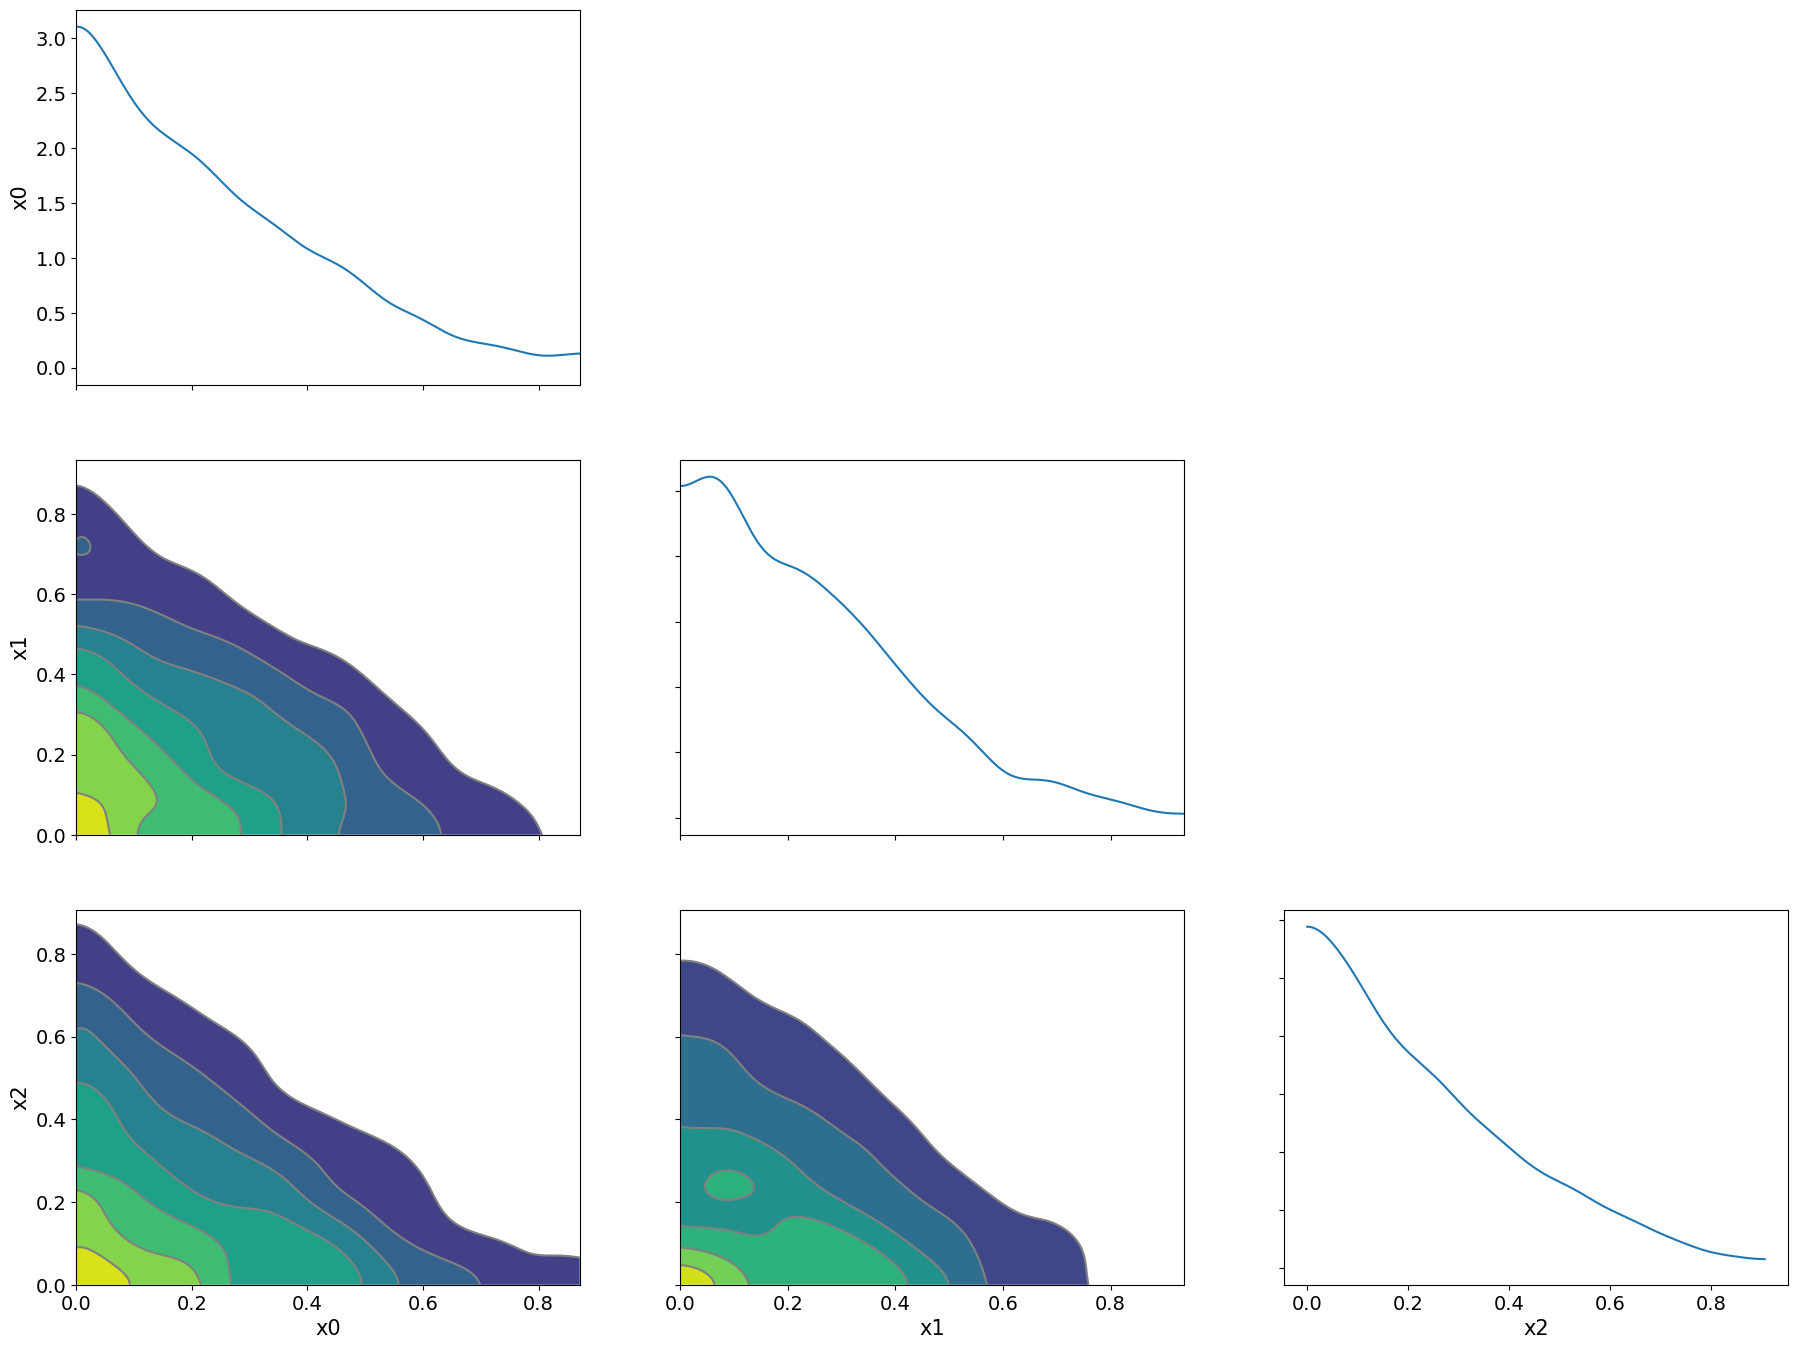

In [8]:
arviz.plot_pair(arviz.dict_to_dataset({f"x{i}": samples[:,:,i].flatten() for i in range(3)}), kind="kde", marginals=True)
plt.show()

Remove testing database and close connections.

In [9]:
client_sampler.disconnect()
client_main.execute(f"DROP DATABASE {db_name}")
client_main.disconnect()